###       Notebook on CHIVI expts !!

In [1]:
import sys, os
sys.path.append('..')
sys.path.append('../..')
import autograd
import pickle
import pystan


In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       perturbed_black_box_vi,
                       make_stan_log_density,
                       adagrad_optimize, 
                       adagrad_perturb_optimize
                      )
from experiments import (get_samples_and_log_weights, 
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

In [3]:

from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

In [4]:

regression_model_code = """data {
  int<lower=0> N;   // number of observations
  int<lower=0> D;   // number of observations
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[D] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(40, x * beta, 1);  // likelihood
  #y ~ normal( x * beta, 0.5);  // likelihood
}"""

In [5]:
try:
    sm = pickle.load(open('robust_reg_model_3.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_3.pkl', 'wb') as f:
        pickle.dump(sm, f)



#### the posterior is almost isotropic with very small correlation ...   D=10, N=60

In [11]:
N=60
k=10
SEED= 5080
alpha=1.
noise_sigma = 0.6
noise_var = noise_sigma**2
rho = 0.05
regression_data = data_generator_linear(N, k, alpha=alpha,
#                                                     noise_variance=noise_var,

rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

In [12]:
os.makedirs('../figures', exist_ok=True)
lims = dict(xlim=[-2.5,0], ylim=[-1.5,0.5])

In [13]:
#data = dict(N=N, x=x, y=y, D=k)
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [14]:

true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [15]:
print(true_mean)
print(np.log(true_std))


[-1.59371517 -0.90218746  0.27211114  0.18630648 -0.76258269 -0.7444907
 -0.11656998  0.00694012 -0.39206224  0.98548088]
[-2.06021684 -1.92728131 -2.0001132  -1.95557632 -1.92877887 -1.93383563
 -1.94081715 -1.86810737 -1.8702304  -2.03732943]


In [16]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=40)
stan_log_density = make_stan_log_density(fit)
chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_g_var_family, stan_log_density, 2000)
chivi_t_mf_objective_and_grad_pd = black_box_chivi(2, mf_t_var_family, stan_log_density, 2000)
chivi_fr_objective_and_grad_pd = black_box_chivi(2, fr_g_var_family, stan_log_density, 2000)

In [17]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 50.771: 100%|██████████| 5000/5000 [00:27<00:00, 182.90it/s]


In [43]:
print(true_mean)
print(np.log(true_std))
print(klvi_var_param)

[-1.59371517 -0.90218746  0.27211114  0.18630648 -0.76258269 -0.7444907
 -0.11656998  0.00694012 -0.39206224  0.98548088]
[-2.06021684 -1.92728131 -2.0001132  -1.95557632 -1.92877887 -1.93383563
 -1.94081715 -1.86810737 -1.8702304  -2.03732943]
[-1.5911973  -0.90412192  0.27301659  0.18606198 -0.76492145 -0.74872406
 -0.11427808  0.00538879 -0.39284756  0.98380304 -2.20331677 -2.1057352
 -2.11917326 -2.10818631 -2.11253288 -2.07330881 -2.13968012 -2.04006754
 -2.07059502 -2.19707326]


####  plot the true posterior and apprximate posterior for the first two dimensions
True is in black, and approximate is in red

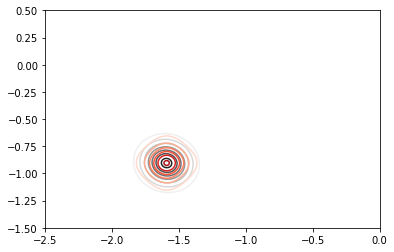

In [47]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims,
                               savepath='../figures/robust-regression-mf-klvi.pdf', aux_var = true_mean[2:])

#### Let us consider two runs, we will use the KLVI optimised params as the initialisation ....

####  Let us first see a good run (with such good initialisation and  dof = 4) on simple simulated linear regression ....

In [52]:
mf_t_var_family = mean_field_t_variational_family(k, 4.5)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
init_param1[k:] += 0.1

(20,)


In [56]:
a,b,c,d = adagrad_optimize(3000, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.01)

Average Loss = -34.625: 100%|██████████| 3000/3000 [01:30<00:00, 33.03it/s]


[-1.5911973  -0.90412192  0.27301659  0.18606198 -0.76492145 -0.74872406
 -0.11427808  0.00538879 -0.39284756  0.98380304 -2.20331677 -2.1057352
 -2.11917326 -2.10818631 -2.11253288 -2.07330881 -2.13968012 -2.04006754
 -2.07059502 -2.19707326]
[-1.59474233 -0.90292358  0.27402565  0.18778691 -0.76383072 -0.74527407
 -0.11451716  0.00659957 -0.39128955  0.9816983  -2.17069764 -2.01525239
 -2.10298458 -2.05138833 -2.02343437 -2.05467574 -2.03508205 -1.97819083
 -1.95081151 -2.16906017]
[-1.59593072e+00 -8.97504240e-01  2.69674401e-01  1.91394647e-01
 -7.61297243e-01 -7.45678265e-01 -1.13541144e-01  7.24683834e-04
 -3.92368076e-01  9.81496638e-01 -2.17142408e+00 -2.01757310e+00
 -2.10062340e+00 -2.05476026e+00 -2.02285966e+00 -2.05235507e+00
 -2.04048528e+00 -1.98114247e+00 -1.95479796e+00 -2.17488734e+00]
[-1.59371517 -0.90218746  0.27211114  0.18630648 -0.76258269 -0.7444907
 -0.11656998  0.00694012 -0.39206224  0.98548088]
[-2.06021684 -1.92728131 -2.0001132  -1.95557632 -1.92877887 -1

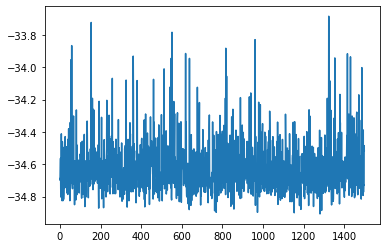

In [57]:
print(klvi_var_param)
print(a)
print(b[-1])
print(true_mean)
print(np.log(true_std))

plt.plot(c[-1500:])

#### same plot as above with chivi

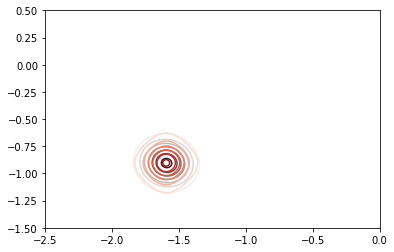

In [58]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, a, **lims,
                               savepath='../figures/robust-regression-mf-chivi.pdf', aux_var = true_mean[2:])

#### Now let us see a bad run , we start with the same location parameters but add a positive value=1.4 to each std dev. parameter.

In [66]:
mf_t_var_family = mean_field_t_variational_family(k, 4.5)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
### just adding some positive value to initial std dev..
init_param1[k:] += 1.4

(20,)


In [67]:
a1,b1,c1,d1 = adagrad_optimize(3000, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.01)

Average Loss = -416.88: 100%|██████████| 3000/3000 [01:30<00:00, 33.25it/s]


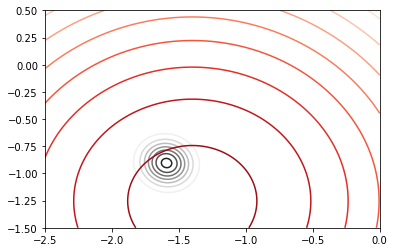

In [69]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, a1, **lims,
                               savepath='../figures/robust-regression-mf-chivi-bad.pdf', aux_var = true_mean[2:])